In [2]:
import numpy as np
import pandas as pd
import scanpy as sc
from gears import PertData
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

In [17]:
adata = sc.read_h5ad('./gears_data/norman_igtp_ori.h5ad')
adata.X.shape

(111445, 7000)

In [18]:
adata.var["gene_name"] = adata.var.index
adata.var = adata.var.set_index('ensemble_id').rename_axis('gene_id', axis=1)
adata.var = adata.var[["gene_name"]]
print(adata.var.shape)
adata.var.head(2)

(7000, 1)


gene_id,gene_name
ensemble_id,
ENSG00000238009,RP11-34P13.7
ENSG00000239945,RP11-34P13.8


In [20]:
adata.obs.rename(columns={"perturbation": "condition"}, inplace=True)
#adata.obs.rename(columns={"celltype": "cell_type"}, inplace=True)
adata.obs.rename(columns={"cell_line": "cell_type"}, inplace=True)

In [21]:
adata.obs["condition"] = adata.obs["condition"].replace('control', 'ctrl')
adata.obs["condition"] = adata.obs["condition"].str.replace('_', '+')

In [22]:
adata.obs['Has_Plus'] = adata.obs['condition'].str.contains(r'\+')
adata.obs['condition'] = adata.obs.apply(lambda row: row['condition'] + '+ctrl' if not row['Has_Plus'] else row['condition'], axis=1)
adata.obs = adata.obs.drop(columns=['Has_Plus'])

In [23]:
adata.obs = adata.obs[["condition","cell_type"]]
adata.obs["condition"] = adata.obs["condition"].replace('ctrl+ctrl', 'ctrl')

In [24]:
adata.obs.head()

,condition,cell_type
TTGAACGAGACTCGGA,ARID1A+ctrl,K562
CGTTGGGGTGTTTGTG,BCORL1+ctrl,K562
GAACCTAAGTGTTAGA,FOSB+ctrl,K562
CCTTCCCTCCGTCATC,SET+KLF1,K562
TCAATCTGTCTTTCAT,OSR2+ctrl,K562


In [25]:
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata,n_top_genes=5000, subset=True)

In [26]:
pert_data = PertData('./gears_data/pert_test1') # specific saved folder

Found local copy...


In [ ]:
pert_data.new_data_process(dataset_name = 'norman_igtp', adata = adata)

Downloading...
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 9.46M/9.46M [00:02<00:00, 3.48MiB/s]
Downloading...
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 559k/559k [00:00<00:00, 3.37MiB/s]
Creating pyg object for each cell in the data...
Creating dataset file...
  7%|███████▍                                                                                                | 17/237 [2:03:24<28:32:02, 466.92s/it]

LYL1+IER5L


 25%|█████████████████████████▉                                                                              | 59/237 [5:45:35<24:34:11, 496.92s/it]

IER5L+ctrl


 32%|█████████████████████████████████▎                                                                      | 76/237 [7:37:45<19:29:02, 435.66s/it]

In [27]:
pert_data.load(data_path = './gears_data/pert_test1/norman_igtp') # load the processed data, the path is saved folder + dataset_name

Found local copy...
These perturbations are not in the GO graph and their perturbation can thus not be predicted
['LYL1+IER5L' 'IER5L+ctrl' 'KIAA1804+ctrl']
Local copy of pyg dataset is detected. Loading...
Done!


In [28]:
pert_data.prepare_split(split = 'simulation', seed = 1) # get data split with seed
pert_data.get_dataloader(batch_size = 256, test_batch_size = 512) # prepare data loader

Local copy of split is detected. Loading...
Simulation split test composition:
combo_seen0:9
combo_seen1:44
combo_seen2:20
unseen_single:26
Done!
Creating dataloaders....
Done!


here1


In [100]:
pert_data.adata.obs.shape

(110139, 5)

In [ ]:
from iGEARS import GEARS

In [30]:
model_name = 'igears_norman'
igears_model = GEARS(pert_data, device = 'cuda:4', 
                         weight_bias_track = False, 
                         proj_name = 'gears', 
                         exp_name = model_name)

In [82]:
igears_model.model_initialize(hidden_size = 64)

Found local copy...


In [83]:
igears_model.train(epochs = 20)

Start Training...
Epoch 1 Step 1 Train Loss: 0.5371
Epoch 1 Step 51 Train Loss: 0.5923
Epoch 1 Step 101 Train Loss: 0.5800
Epoch 1 Step 151 Train Loss: 0.6051
Epoch 1 Step 201 Train Loss: 0.5918
Epoch 1: Train Overall MSE: 0.0029 Validation Overall MSE: 0.0033. 
Train Top 20 DE MSE: 0.0850 Validation Top 20 DE MSE: 0.1037. 
Epoch 2 Step 1 Train Loss: 0.6168
Epoch 2 Step 51 Train Loss: 0.5952
Epoch 2 Step 101 Train Loss: 0.5986
Epoch 2 Step 151 Train Loss: 0.5854
Epoch 2 Step 201 Train Loss: 0.5978
Epoch 2: Train Overall MSE: 0.0034 Validation Overall MSE: 0.0054. 
Train Top 20 DE MSE: 0.0615 Validation Top 20 DE MSE: 0.1103. 
Epoch 3 Step 1 Train Loss: 0.5772
Epoch 3 Step 51 Train Loss: 0.5887
Epoch 3 Step 101 Train Loss: 0.5842
Epoch 3 Step 151 Train Loss: 0.6053
Epoch 3 Step 201 Train Loss: 0.5888
Epoch 3: Train Overall MSE: 0.0024 Validation Overall MSE: 0.0031. 
Train Top 20 DE MSE: 0.0492 Validation Top 20 DE MSE: 0.0801. 
Epoch 4 Step 1 Train Loss: 0.6206
Epoch 4 Step 51 Train Lo

In [84]:
igears_model.save_model('igears')

In [31]:
igears_model.load_pretrained('igears')

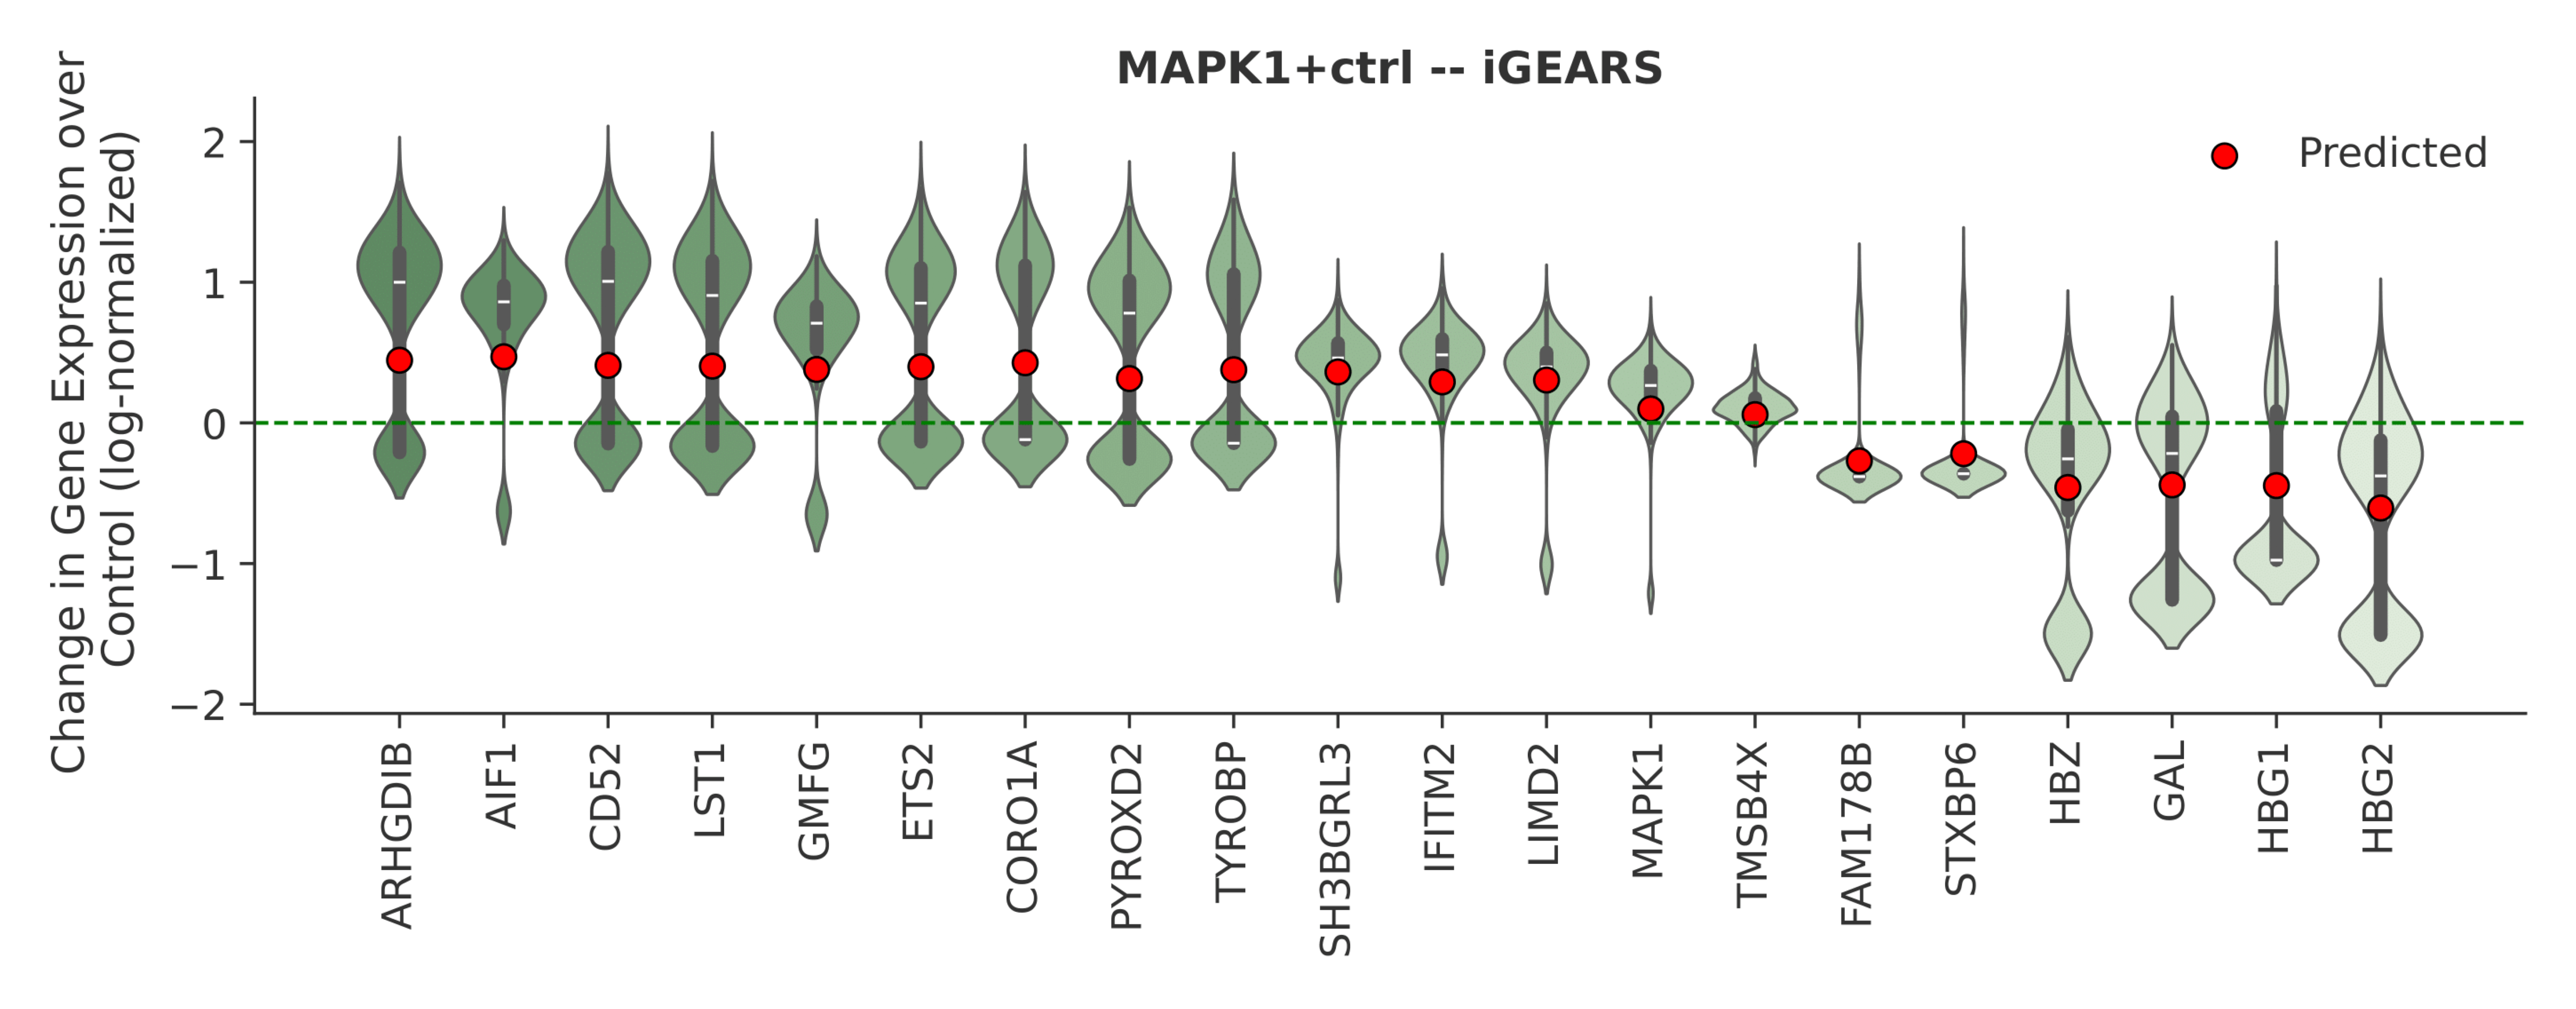

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm 

sns.set_theme(style="ticks", rc={"axes.facecolor": (0, 0, 0, 0)}, font_scale=1.5)


for query in tqdm(pert_data.adata.obs.condition.unique().tolist()):
    # Your existing code to compute 'truth', 'pred', 'genes', etc.

    #print(query)

    try:
        adata = igears_model.adata
        gene2idx = igears_model.node_map
        cond2name = dict(adata.obs[['condition', 'condition_name']].values)
        gene_raw2id = dict(zip(adata.var.index.values, adata.var.gene_name.values))

        de_idx = [gene2idx[gene_raw2id[i]] for i in
                adata.uns['top_non_dropout_de_20'][cond2name[query]]]
        genes = [gene_raw2id[i] for i in
                    adata.uns['top_non_dropout_de_20'][cond2name[query]]]
        truth = adata[adata.obs.condition == query].X.toarray()[:, de_idx]

        query_ = [q for q in query.split('+') if q != 'ctrl']
        pred = igears_model.predict([query_])['_'.join(query_)][de_idx]
        ctrl_means = adata[adata.obs['condition'] == 'ctrl'].to_df().mean()[
            de_idx].values

        pred = pred - ctrl_means
        truth = truth - ctrl_means

        # Calculate mean values for each gene and sort genes by mean value (descending order)
        mean_values = np.mean(truth, axis=0)
        sorted_indices = np.argsort(mean_values)[::-1]  # Reverse order for descending
        sorted_genes = np.array(genes)[sorted_indices]
        sorted_truth = truth[:, sorted_indices]

        # Sort 'pred' using the same indices as 'truth' and 'genes'
        sorted_pred = pred[sorted_indices]

        # Create a DataFrame for seaborn
        df = pd.DataFrame(sorted_truth, columns=sorted_genes)

        # Custom color palette from darker to lighter, with a lighter dark shade
        n_genes = len(sorted_genes)
        #palette = sns.cubehelix_palette(n_genes, dark = 0.3, rot=-.1, light=0.9, reverse=True)  # Lighter dark shade

        palette = sns.cubehelix_palette(n_genes+15, start = 2.1, rot=-.1, light=0.9, reverse=True)[15:]
        # Change the color of the first violin plot to pink
        #palette[0] = 'pink'

        plt.figure(figsize=[16.5, 4.5])
        plt.title(str(query)+" -- iGEARS", fontweight='bold')

        # Create violin plot with sorted data and modified palette
        sns.violinplot(data=df, inner="box", palette=palette)

        # Add 'pred' as dots on the violin plot with a label for the legend
        x_coords = np.arange(len(sorted_genes))
        plt.scatter(x_coords, sorted_pred, color='red', edgecolor='black', zorder=2, label='Predicted',s=100)

        # Add legend to the plot with no background color
        plt.legend(frameon=False)

        plt.axhline(0, linestyle="dashed", color='green')

        ax = plt.gca()
        ax.xaxis.set_ticklabels(sorted_genes, rotation=90)

        plt.ylabel("Change in Gene Expression over \n Control (log-normalized)", labelpad=10)
        plt.tick_params(axis='x', which='major', pad=5)
        plt.tick_params(axis='y', which='major', pad=5)
        sns.despine()
        plt.savefig("igtp_pert_violin_plot/"+str(query)+"_perturbation.pdf", format='pdf', bbox_inches='tight')
        #plt.show()
    except:
        print(query)
        pass

In [40]:
import pickle
norman_path='./save_model/NormanWeissman2019_filtered/processed_data/GO_merged_PCzinb_uniform_7000.pkl'

with open(norman_path, 'rb') as file:
    norman_data = pickle.load(file)
    
print(norman_data.keys())

dict_keys(['data_x_s', 'mask_dict', 'args', 'seq_gene_df', 'seq_gene_df_su', 'TP_df', 'ppi_df_1', 'data'])


In [106]:
gene_ls_tp = []
for i in range(norman_data["TP_df"].shape[0]):
    #if ("CDKN1C" in norman_data["TP_df"].TP_gene.iloc[i]) or ("CDKN1B" in norman_data["TP_df"].TP_gene.iloc[i]):
    if ("MAPK1" in norman_data["TP_df"].TP_gene.iloc[i]):
        gene_ls_tp.append(norman_data["TP_df"].TP_gene.iloc[i])

In [107]:
gene_ls_tp = [i for sample in gene_ls_tp for i in sample]
gene_ls_tp = np.unique(gene_ls_tp)

In [109]:
gene2idx_ls = list(gene2idx.keys())

In [110]:
predict_igears = igears_model.predict([query_])['_'.join(query_)]

In [111]:
result_indices = [index for index, elem in enumerate(gene2idx_ls) if elem in gene_ls_tp]

In [112]:
selected_elements = [predict_igears[index] for index in result_indices]
remaining_elements = [elem for index, elem in enumerate(predict_igears) if index not in result_indices]

In [114]:
from scipy import stats
# T-test (assuming equal variances)
t_stat, p_val_t = stats.ttest_ind(selected_elements,remaining_elements, equal_var=True)

# Mann-Whitney U test
u_stat, p_val_mannwhitney = stats.mannwhitneyu(selected_elements,remaining_elements)

print(f"T-test p-value: {p_val_t}")
print(f"Mann-Whitney U test p-value: {p_val_mannwhitney}")

T-test p-value: 1.972704105494922e-72
Mann-Whitney U test p-value: 1.2356679119736626e-76


In [115]:
temp_df = pd.DataFrame({'in_tp': ['Within_TPs']*len(selected_elements) + ['Out_of_TPs']*len(remaining_elements),
                   'Values': selected_elements + remaining_elements})

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


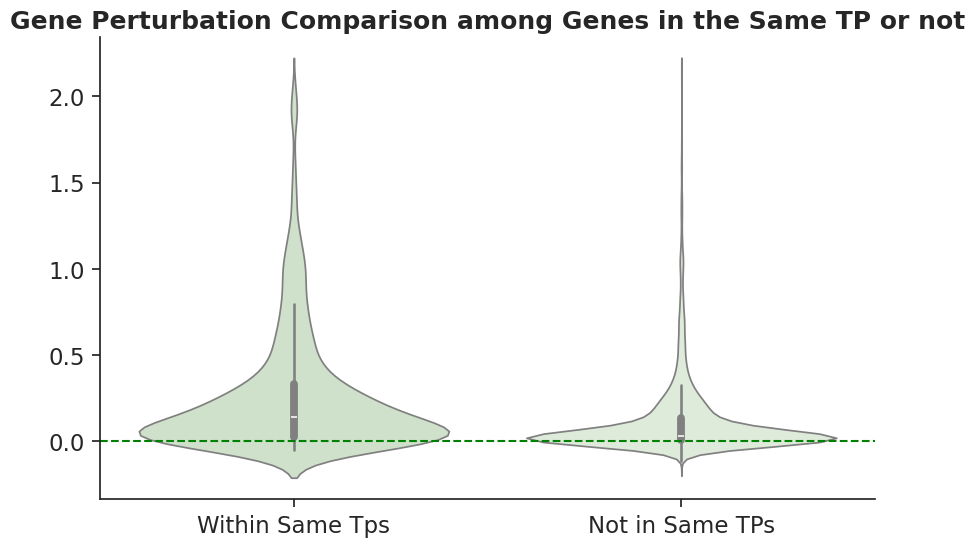

In [135]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Generating sample data for two lists
list1 = temp_df[temp_df.in_tp == "Within_TPs"].Values
list2 = temp_df[temp_df.in_tp != "Within_TPs"].Values


# Custom color palette from darker to lighter, with a lighter dark shade
n_violin = 2
#palette = sns.cubehelix_palette(n_genes, dark = 0.3, rot=-.1, light=0.9, reverse=True)  # Lighter dark shade

palette = sns.cubehelix_palette(n_violin+15, start = 2.1, rot=-.1, light=0.9, reverse=True)[15:]
# Change the color of the first violin plot to pink
#palette[0] = 'pink'

plt.figure(figsize=[10, 6])
plt.title("Gene Perturbation Comparison among Genes in the Same TP or not", fontweight='bold')

# Create violin plot with sorted data and modified palette
df = pd.DataFrame({"Within TPs":list1, "Not in Same TPs":list2})
sns.violinplot(data=df, inner="box", palette=palette)

# Add text for T-test and Mann-Whitney U test p-values
t_test_p_value = 1.97e-72
mann_whitney_p_value = 1.24e-76
#plt.text(0.5, 2, f"T-test p-value: {t_test_p_value:.2e}\nMann-Whitney U test p-value: {mann_whitney_p_value:.2e}",
#         horizontalalignment='center', verticalalignment='center', fontsize=14, color='black')


# Add 'pred' as dots on the violin plot with a label for the legend
x_coords = np.arange(n_violin)
#plt.scatter(x_coords, sorted_pred, color='red', edgecolor='black', zorder=2, label='Predicted',s=100)

# Add legend to the plot with no background color
plt.legend(frameon=False)

plt.axhline(0, linestyle="dashed", color='green')

ax = plt.gca()
#ax.xaxis.set_ticklabels(sorted_genes, rotation=90)
ax.xaxis.set_ticklabels(["Within Same Tps","Not in Same TPs"])

#plt.ylabel("Change in Gene Expression over \n Control (log-normalized)", labelpad=10)
plt.tick_params(axis='x', which='major', pad=5)
plt.tick_params(axis='y', which='major', pad=5)
sns.despine()
plt.savefig("igtp_pert_violin_plot/MAPK1_tp_comparison.pdf", format='pdf', bbox_inches='tight')
plt.show()


